In [ ]:
# Model showing how a market maker can hedge their portfolio without crossing the bid/ask spread
# First examine how to set bid/ask spreads with only a stock portfolio
# Then investigate how to set bid/ask spreads for both stock and options, particularly in an illiquid market

# Avellaneda-Stoikov Model for Trading in a Limit Order Book

We have already seen in class how, with some assumptions, a market maker can sell an option and then trade stock to delta hedge this option.
However, delta hedging in this way incurs costs such as the fees associated with making a trade. The Avellaneda-Stoikov model allows market makers to hedge their risk by adjusting the bid/ask spread in order to encourage orders that offset their current portfolio's risk. This allows them to make use of their role as a market maker in order to avoid crossing the bid/ask spread when hedging their portfolio.

We will first examine this model in the case of a portfolio consisting only of stock. In this model, a market maker desires to avoid taking on a position that is exceedingly long or short on the stock, instead prefering to be risk-neutral and profit simply through a bid-ask spread. Thus, should a market-maker find themselves in a positions where they are long on a particular stock, they will decrease their asking price while simultaneously increasing the fees that an investor would pay to sell them the stock.

Note that, in this model, the market maker does not value the stock equally to the market.  A market maker owning many stocks would like to decrease their position, and thus is not willing to pay market value for another share. The **reservation bid price $r^b$** is the price which the market maker is ambivalent about paying for a stock.  That is, they value their current portfolio equally with one additional stock and $r^b$ less cash. Similarly, the **reservation ask price $r^a$** is the price at which a market maker, with their current portfolio, is ambivalent about selling a share of stock. The average of these two prices is the **reservation price**, and the bid-ask spread is adjusted around this price, not the market value. This reservation price has a closed form solution and can be written as $$r(s,q,t)=s-q\gamma\sigma^2(T-t)$$ where s is the current stock price, q is the current inventory, and T is the terminal time when profits and losses are calculated, and t is the current time.

The main obstacle to implementing such a model is calculating how sell orders (denoted $\lambda^b$) and buy orders ($\lambda^a$) arrive and how the size of these orders are distributed. For simplification, we assume that there are a constant number of buyers and sellers throughout the day (i.e., orders are equally distributed throughout the day). We will model the order arrival process as two Poisson processes, $$\lambda^b(\delta^b)=Ae^{-k\delta^b} \text{ and } \lambda^a(\delta^a)=Ae^{-k\delta^a}$$ where $A$ is the base intensity of trades at market value, $k$ controls how quickly liquidity decays as the price moves away from market value, and $\delta^b, \delta^a$ are the bid/ask spreads.

The main point of the model is to show how, with a more sophisticated bid/ask spread, market makers can tighten the distribution of outcomes while still realizing most of the possible value of their portfolio without ever crossing the bid/ask spread.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [192]:
# Stock Only Parameters
T = 1.0       # total time
N = 200       # time steps
dt = T / N
n_paths = 200 # number of simulated price paths
S0 = 100      # initial price
sigma = 2     # volatility
A = 140       # base intensity
k = 1.5       # liquidity depth
gamma = 0.1   # risk aversion
q0 = 0 #np.random.randn(n_paths) * 10 #starting inventoryv - note that starting with non-zero inventory will diminish PnL

In [194]:
# Vectorized arithmetic Brownian motion
Z = np.random.randn(n_paths, N-1)
S = np.zeros((n_paths, N))
S[:, 0] = S0
S[:, 1:] = S0 + np.cumsum(sigma * np.sqrt(dt) * Z, axis=1)

# Initialize state variables
q_as = np.zeros((n_paths, N))
q_sym = np.zeros((n_paths, N))
cash_as = np.zeros((n_paths, N))
cash_sym = np.zeros((n_paths, N))

q_as[:, 0] = q0
q_sym[:, 0] = q0
cash_as[:, 0] = -q0 * S[:, 0]
cash_sym[:, 0] = -q0 * S[:, 0]

In [200]:
def avellanda_stoikov_stock_only(T, N, dt, n_paths, S0, sigma, A, k, gamma, q0):
    # --- Simulation loop ---
    for i in range(N - 1):
        t = i * dt
        delta = (gamma * sigma**2 * (T - t)) / 2 + (1/gamma) * np.log(1 + gamma / k)
    
        # --- Avellaneda–Stoikov ---
        r = S[:, i] - q_as[:, i] * gamma * sigma**2 * (T - t)
        bid_as = r - delta
        ask_as = r + delta
    
        lambda_bid_as = A * np.exp(-k * (S[:, i] - bid_as))
        lambda_ask_as = A * np.exp(-k * (ask_as - S[:, i]))
        prob_bid_as = lambda_bid_as * dt
        prob_ask_as = lambda_ask_as * dt
    
        buy_exec_as = np.random.rand(n_paths) < prob_bid_as
        sell_exec_as = np.random.rand(n_paths) < prob_ask_as
    
        q_as[:, i+1] = q_as[:, i] + (buy_exec_as.astype(int) - sell_exec_as.astype(int))
        cash_as[:, i+1] = cash_as[:, i] - bid_as * buy_exec_as + ask_as * sell_exec_as
    
        # --- Symmetric baseline ---
        bid_sym = S[:, i] - delta
        ask_sym = S[:, i] + delta
    
        lambda_bid_sym = A * np.exp(-k * (S[:, i] - bid_sym))
        lambda_ask_sym = A * np.exp(-k * (ask_sym - S[:, i]))
        prob_bid_sym = lambda_bid_sym * dt
        prob_ask_sym = lambda_ask_sym * dt
    
        buy_exec_sym = np.random.rand(n_paths) < prob_bid_sym
        sell_exec_sym = np.random.rand(n_paths) < prob_ask_sym
    
        q_sym[:, i+1] = q_sym[:, i] + (buy_exec_sym.astype(int) - sell_exec_sym.astype(int))
        cash_sym[:, i+1] = cash_sym[:, i] - bid_sym * buy_exec_sym + ask_sym * sell_exec_sym

    # --- Wealth computation ---
    PnL_as = cash_as + q_as * S
    PnL_sym = cash_sym + q_sym * S
    
    final_as = PnL_as[:, -1]
    final_sym = PnL_sym[:, -1]
    time = np.linspace(0, T, N)

    # --- Visualization ---
    fig, ax = plt.subplots(2, 1, figsize=(10, 9), sharex=True)
    ax[0].plot(time, S[:50].T, color='gray', alpha=0.3)
    ax[0].plot(time, S.mean(axis=0), color='red', label='Mean Price')
    #ax[0].legend()
    
    ax[1].plot(time, q_as[:50].T, color='blue', alpha=0.2, label='A–S')
    ax[1].plot(time, q_sym[:50].T, color='orange', alpha=0.2, label='Symmetric')
    ax[1].axhline(0, color='k', lw=0.5)
    #ax[1].legend()
    

    
    plt.tight_layout()
    plt.show()
    
    # --- Final PnL comparison ---
    plt.figure(figsize=(6,4))
    plt.hist(final_as, bins=40, alpha=0.6, label='A–S PnL')
    plt.hist(final_sym, bins=40, alpha=0.6, label='Symmetric PnL')
    plt.title("Final PnL Distribution Comparison")
    plt.xlabel("PnL")
    plt.ylabel("Frequency")
    #plt.legend()
    plt.show()
    
    # --- Print statistics ---
    print("A–S Mean Final PnL:", np.mean(final_as))
    print("Symmetric Mean Final PnL:", np.mean(final_sym))
    print("A–S Std Dev:", np.std(final_as))
    print("Symmetric Std Dev:", np.std(final_sym))

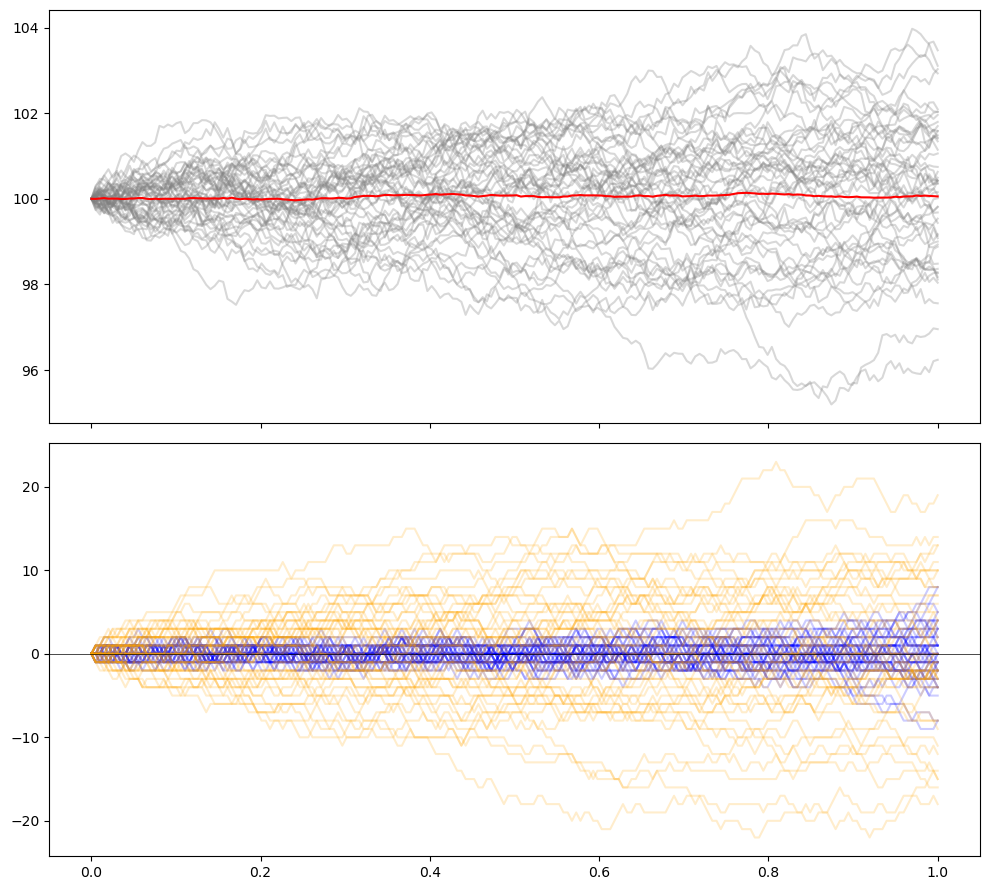

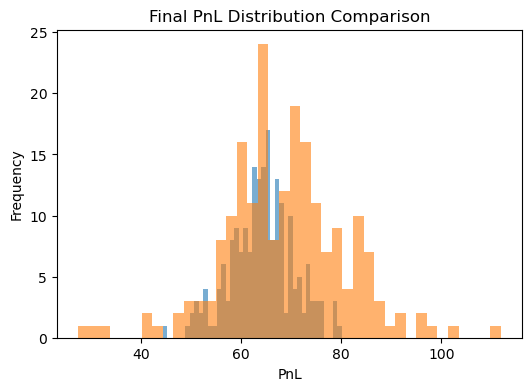

A–S Mean Final PnL: 64.1429057064549
Symmetric Mean Final PnL: 68.73492496420606
A–S Std Dev: 6.26920903075123
Symmetric Std Dev: 12.262911269580574


In [202]:
avellanda_stoikov_stock_only(T, N, dt, n_paths, S0, sigma, A, k, gamma, q0)

# Stoikov-Saglam Model - Extending to Market-Making with Options

Thus far, we have only examined how to hedge portfolios with stocks; we have not examined hedging portfolios that contain option contracts.  However, as a market maker, we can extend this process of adjusting the bid-ask spread to effectively hedge a portfolio that includes option contracts. For a slightly more interesting discussion, we also assume that the market is relatively illiquid. Thus, the market maker is actually unable to hedge in the usual manner, and must rely on adjusting the bid-ask spread to limit volatility.

In [316]:
# --- Stock + Option Parameters ---
n_paths = 20000
n_steps = 200
T = 1.0                     # trading horizon (end of trading)
T_mat = 10                 # option maturity (option expires after T)
dt = T / n_steps

gamma = 0.006                # risk aversion (in penalty factor)
sigma = 0.01                 # underlying spot vol (for path sim and penalty)
r = 0.0                     # interest rate
S0, K = 100.0, 100.0        # initial stock price and strike

# Liquidity parameters
A, B = 40, 2000             # stock market liquidity (linear)
C, D = 40, 200             # option market liquidity (linear)

# Overnight jump parameters (log-normal jump on S at time T)
jump_prob = 1.0             # probability a jump occurs
jump_mu = 0.0               # mean of jump
jump_sigma = 0.05           # volatility of jump
jump_lambda = 0.25          #just for the Poisson process model

np.random.seed(42)

In [318]:
# --- Black-Scholes helpers and GBM vectorization---
def bs_call_price(S, K, tau, r, sigma):
    """Vectorized BS call price (tau may be scalar or array)."""
    S = np.asarray(S)
    tau = np.asarray(tau)
    C = np.zeros_like(S, dtype=float)
    # handle tau==0 (expiry)
    alive = tau > 1e-12
    if np.any(~alive):
        C[~alive] = np.maximum(S[~alive] - K, 0.0)
    if np.any(alive):
        t = tau[alive]
        d1 = (np.log(S[alive] / K) + (r + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))
        d2 = d1 - sigma * np.sqrt(t)
        C[alive] = S[alive] * norm.cdf(d1) - K * np.exp(-r * t) * norm.cdf(d2)
    return C
    

def bs_delta(S, K, tau, r, sigma):
    """Vectorized BS call delta."""
    S = np.asarray(S)
    tau = np.asarray(tau)
    Delta = np.zeros_like(S, dtype=float)
    alive = tau > 1e-12
    if np.any(~alive):
        Delta[~alive] = (S[~alive] > K).astype(float)
    if np.any(alive):
        t = tau[alive]
        d1 = (np.log(S[alive] / K) + (r + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))
        Delta[alive] = norm.cdf(d1)
    return Delta

def generate_gbm_paths(S0, sigma, T, r, mu, n_paths, n_steps):
    dt = T / n_steps
    Z = np.random.randn(n_paths, n_steps)
    log_returns = (mu + r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
    exponent = np.cumsum(log_returns, axis=1)
    # ensure S0 is 2D (n_paths, 1)
    S0 = np.asarray(S0).reshape(-1, 1)
    S = S0 * np.exp(exponent)
    S = np.insert(S, 0, S0, axis=1)
    return S

In [320]:
# --- Initialize arrays ---
time = np.linspace(0, T, n_steps + 1)
tau_grid = T_mat - time                # time-to-maturity for option pricing at each step

q_s = np.zeros((n_paths, n_steps + 1), dtype=int)
q_o = np.zeros((n_paths, n_steps + 1), dtype=int)
cash = np.zeros((n_paths, n_steps + 1), dtype=float)

S = generate_gbm_paths(S0, sigma, T, r, mu, n_paths, n_steps)

In [322]:
def stoikov_gbm_single_day(n_steps, tau, S, K, r, sigma, gamma, A, B, C, D, mu, jump_prob, jump_mu, jump_sigma, T_mat, dt):
    "Simulate Stoikov bid/ask strategy for n_paths for a single day; Stock prices follow a GBM with a jump after trading day ends"
    "Also simulates a baseline using symmetric bid/ask"
    fixed_eps_s = A / (2 * B)
    fixed_eps_o = C / (2 * D)
    
    # Arrays for baseline PnL simulation
    q_s_fixed = np.zeros_like(q_s)
    q_o_fixed = np.zeros_like(q_o)
    cash_fixed = np.zeros_like(cash)
    
    for i in range(n_steps):
        t = i * dt
        tau = tau_grid[i]
    
        # use precomputed prices
        S_t = S[:, i]
        
        C_mid = bs_call_price(S_t, K, tau, r, sigma)
        Delta = bs_delta(S_t, K, tau, r, sigma)
        net_delta = q_s[:, i] + q_o[:, i] * Delta
        
        adj = gamma * sigma**2 * (T - t) * (S_t**2)
        
        eps_a_s = np.clip(A/(2*B) - adj * (net_delta - 0.5), 0.0, A / B)
        eps_b_s = np.clip(A/(2*B) + adj * (net_delta + 0.5), 0.0, A / B)
        
        eps_a_o = np.clip(C/(2*D) - adj * Delta * (net_delta - 0.5 * Delta), 0.0, C / D)
        eps_b_o = np.clip(C/(2*D) + adj * Delta * (net_delta + 0.5 * Delta), 0.0, C / D)
        
        bid_s = S_t - eps_b_s
        ask_s = S_t + eps_a_s
        bid_o = C_mid - eps_b_o
        ask_o = C_mid + eps_a_o
        
        lam_s_b = np.maximum(A - B * eps_b_s, 0.0)
        lam_s_a = np.maximum(A - B * eps_a_s, 0.0)
        lam_o_b = np.maximum(C - D * eps_b_o, 0.0)
        lam_o_a = np.maximum(C - D * eps_a_o, 0.0)
        
        p_s_b = np.clip(lam_s_b * dt, 0.0, 0.999)
        p_s_a = np.clip(lam_s_a * dt, 0.0, 0.999)
        p_o_b = np.clip(lam_o_b * dt, 0.0, 0.999)
        p_o_a = np.clip(lam_o_a * dt, 0.0, 0.999)

        # one set of random uniforms per event type
        u_s_b = np.random.rand(n_paths)
        u_s_a = np.random.rand(n_paths)
        u_o_b = np.random.rand(n_paths)
        u_o_a = np.random.rand(n_paths)
        
        # dynamic Stoikov model
        buy_s  = u_s_b < p_s_b
        sell_s = u_s_a < p_s_a
        buy_o  = u_o_b < p_o_b
        sell_o = u_o_a < p_o_a
        
        q_s[:, i+1] = q_s[:, i] + buy_s.astype(int) - sell_s.astype(int)
        q_o[:, i+1] = q_o[:, i] + buy_o.astype(int) - sell_o.astype(int)
        cash[:, i+1] = cash[:, i] - bid_s * buy_s + ask_s * sell_s - bid_o * buy_o + ask_o * sell_o

        #--- Calculation for baseline
        fixed_bid_s = S[:, i] - fixed_eps_s
        fixed_ask_s = S[:, i] + fixed_eps_s
        fixed_bid_o = C_mid - fixed_eps_o
        fixed_ask_o = C_mid + fixed_eps_o
    
        # linear arrival rates
        fixed_lam_s_b = np.maximum(A - B * fixed_eps_s, 0.0)
        fixed_lam_s_a = np.maximum(A - B * fixed_eps_s, 0.0)
        fixed_lam_o_b = np.maximum(C - D * fixed_eps_o, 0.0)
        fixed_lam_o_a = np.maximum(C - D * fixed_eps_o, 0.0)
    
        fixed_p_s_b = np.clip(fixed_lam_s_b * dt, 0.0, 0.999)
        fixed_p_s_a = np.clip(fixed_lam_s_a * dt, 0.0, 0.999)
        fixed_p_o_b = np.clip(fixed_lam_o_b * dt, 0.0, 0.999)
        fixed_p_o_a = np.clip(fixed_lam_o_a * dt, 0.0, 0.999)
    
        # baseline model (same uniform draws, but different thresholds)
        fixed_buy_s  = u_s_b < fixed_p_s_b
        fixed_sell_s = u_s_a < fixed_p_s_a
        fixed_buy_o  = u_o_b < fixed_p_o_b
        fixed_sell_o = u_o_a < fixed_p_o_a
    
        q_s_fixed[:, i+1] = q_s_fixed[:, i] + fixed_buy_s.astype(int) - fixed_sell_s.astype(int)
        q_o_fixed[:, i+1] = q_o_fixed[:, i] + fixed_buy_o.astype(int) - fixed_sell_o.astype(int)
        cash_fixed[:, i+1] = (cash_fixed[:, i]
                      - fixed_bid_s * fixed_buy_s + fixed_ask_s * fixed_sell_s
                      - fixed_bid_o * fixed_buy_o + fixed_ask_o * fixed_sell_o)

    # --- Overnight jump at t = T: apply multiplicative log-normal jump to S[:, -1] -> S_Tplus ---
    # jump occurs with probability `jump_prob` independently per path (or set jump_prob=1.0 to always jump)
    u = np.random.rand(n_paths)
    jump_happens = u < jump_prob
    # log-normal multiplicative factor
    eps_jump = np.random.randn(n_paths)
    mult_factors = np.exp(jump_mu - 0.5 * jump_sigma**2 + jump_sigma * eps_jump)  # E[factor]=exp(jump_mu)
    # apply jump where jump_happens True; otherwise remain
    S_Tplus = S[:, -1].copy()
    S_Tplus[jump_happens] = S_Tplus[jump_happens] * mult_factors[jump_happens]
    
    # recompute option final price at time T (time-to-mat = T_mat - T)
    final_tau = T_mat - T
    C_final = bs_call_price(S_Tplus, K, final_tau, r, sigma)
    
    # final mark-to-mid wealth
    final_wealth = cash[:, -1] + q_s[:, -1] * S_Tplus + q_o[:, -1] * C_final
    PnL = final_wealth.copy()
    # --- Diagnostics / plots ---
    #print("Mean final PnL:", PnL.mean(), "Std:", PnL.std())
    
    # quick plots for a few example paths
    plt.figure(figsize=(10,6))
    plt.plot(time, S[:6, :].T, alpha=0.6)
    plt.title('Sample stock paths (during trading horizon)')
    plt.xlabel('t'); plt.ylabel('S'); plt.show()
    
    plt.figure(figsize=(8,4))
    plt.hist(PnL, bins=60)
    plt.title('Final PnL distribution (after overnight jump)')
    plt.xlabel('PnL'); plt.ylabel('Frequency'); plt.show()
    # Final wealth after overnight jump
    C_final_fixed = bs_call_price(S_Tplus, K, T_mat - T, r, sigma)
    final_wealth_fixed = cash_fixed[:, -1] + q_s_fixed[:, -1] * S_Tplus + q_o_fixed[:, -1] * C_final_fixed
    PnL_fixed = final_wealth_fixed.copy()
    
    # Compare histograms
    plt.hist(PnL, bins=50, alpha=0.6, label='Stoikov dynamic')
    plt.hist(PnL_fixed, bins=50, alpha=0.6, label='Fixed spreads')
    plt.legend()
    plt.xlabel('PnL'); plt.ylabel('Frequency')
    plt.title('PnL distributions: Stoikov vs Fixed Spread')
    plt.show()
    
    print(f"Dynamic quotes mean={PnL.mean():.4f}, std={PnL.std():.4f}")
    print(f"Fixed spreads mean={PnL_fixed.mean():.4f}, std={PnL_fixed.std():.4f}")

In [324]:
def stoikov_constant_single_day(n_paths, n_steps, S0, K, r, sigma, gamma, A, B, C, D, jump_prob, jump_mu, jump_sigma, T_mat, T, dt, random_seed=None):
    """
    Stoikov-style simulation for one trading day with constant stock price S0,
    then a single lognormal jump after the market closes.
    Includes baseline (fixed symmetric spreads) for proper comparison.
    """

    if random_seed is not None:
        np.random.seed(random_seed)

    # === Initialize arrays ===
    q_s = np.zeros((n_paths, n_steps+1), dtype=int)
    q_o = np.zeros((n_paths, n_steps+1), dtype=int)
    cash = np.zeros((n_paths, n_steps+1), dtype=float)

    q_s_fixed = np.zeros_like(q_s)
    q_o_fixed = np.zeros_like(q_o)
    cash_fixed = np.zeros_like(cash)

    # constant price path
    S = np.full((n_paths, n_steps+1), S0)
    tau_grid = np.linspace(T_mat, T_mat - T, n_steps+1)
    time = np.linspace(0, T, n_steps+1)

    # fixed spread baselines (half-spreads)
    fixed_eps_s = A / (2 * B)
    fixed_eps_o = C / (2 * D)

    # counters for diagnostics
    fills_dynamic = {"s_buy":0, "s_sell":0, "o_buy":0, "o_sell":0}
    fills_fixed   = {"s_buy":0, "s_sell":0, "o_buy":0, "o_sell":0}

    # === simulate trading ===
    for i in range(n_steps):
        t = i * dt
        tau = tau_grid[i]
        S_t = S[:, i]

        # option price and delta
        C_mid = bs_call_price(S_t, K, tau, r, sigma)
        Delta = bs_delta(S_t, K, tau, r, sigma)
        net_delta = q_s[:, i] + q_o[:, i] * Delta

        # Stoikov spreads
        adj = gamma * sigma**2 * (T - t) * (S_t**2)
        eps_a_s = np.clip(A/(2*B) - adj * (net_delta - 0.5), 0.0, A / B)
        eps_b_s = np.clip(A/(2*B) + adj * (net_delta + 0.5), 0.0, A / B)
        eps_a_o = np.clip(C/(2*D) - adj * Delta * (net_delta - 0.5*Delta), 0.0, C / D)
        eps_b_o = np.clip(C/(2*D) + adj * Delta * (net_delta + 0.5*Delta), 0.0, C / D)

        bid_s = S_t - eps_b_s
        ask_s = S_t + eps_a_s
        bid_o = C_mid - eps_b_o
        ask_o = C_mid + eps_a_o

        # dynamic arrival rates -> probabilities
        lam_s_b = np.maximum(A - B * eps_b_s, 0.0)
        lam_s_a = np.maximum(A - B * eps_a_s, 0.0)
        lam_o_b = np.maximum(C - D * eps_b_o, 0.0)
        lam_o_a = np.maximum(C - D * eps_a_o, 0.0)

        p_s_b = np.clip(lam_s_b * dt, 0.0, 0.999)
        p_s_a = np.clip(lam_s_a * dt, 0.0, 0.999)
        p_o_b = np.clip(lam_o_b * dt, 0.0, 0.999)
        p_o_a = np.clip(lam_o_a * dt, 0.0, 0.999)

        # fixed spread probabilities
        fixed_lam_s_b = np.maximum(A - B * fixed_eps_s, 0.0)
        fixed_lam_s_a = np.maximum(A - B * fixed_eps_s, 0.0)
        fixed_lam_o_b = np.maximum(C - D * fixed_eps_o, 0.0)
        fixed_lam_o_a = np.maximum(C - D * fixed_eps_o, 0.0)

        fixed_p_s_b = np.clip(fixed_lam_s_b * dt, 0.0, 0.999)
        fixed_p_s_a = np.clip(fixed_lam_s_a * dt, 0.0, 0.999)
        fixed_p_o_b = np.clip(fixed_lam_o_b * dt, 0.0, 0.999)
        fixed_p_o_a = np.clip(fixed_lam_o_a * dt, 0.0, 0.999)

        # draw uniforms once per step, share them between strategies
        u_mat = np.random.rand(n_paths, 4)

        # dynamic execution indicators
        buy_s  = u_mat[:, 0] < p_s_b
        sell_s = u_mat[:, 1] < p_s_a
        buy_o  = u_mat[:, 2] < p_o_b
        sell_o = u_mat[:, 3] < p_o_a

        # baseline execution indicators (same uniforms, different thresholds)
        fixed_buy_s  = u_mat[:, 0] < fixed_p_s_b
        fixed_sell_s = u_mat[:, 1] < fixed_p_s_a
        fixed_buy_o  = u_mat[:, 2] < fixed_p_o_b
        fixed_sell_o = u_mat[:, 3] < fixed_p_o_a

        # update counters
        fills_dynamic["s_buy"]  += buy_s.sum()
        fills_dynamic["s_sell"] += sell_s.sum()
        fills_dynamic["o_buy"]  += buy_o.sum()
        fills_dynamic["o_sell"] += sell_o.sum()

        fills_fixed["s_buy"]  += fixed_buy_s.sum()
        fills_fixed["s_sell"] += fixed_sell_s.sum()
        fills_fixed["o_buy"]  += fixed_buy_o.sum()
        fills_fixed["o_sell"] += fixed_sell_o.sum()

        # --- Stoikov updates ---
        q_s[:, i+1] = q_s[:, i] + buy_s.astype(int) - sell_s.astype(int)
        q_o[:, i+1] = q_o[:, i] + buy_o.astype(int) - sell_o.astype(int)
        cash[:, i+1] = (cash[:, i]
                        - bid_s * buy_s + ask_s * sell_s
                        - bid_o * buy_o + ask_o * sell_o)

        # --- Baseline (fixed spreads) updates ---
        fixed_bid_s = S_t - fixed_eps_s
        fixed_ask_s = S_t + fixed_eps_s
        fixed_bid_o = C_mid - fixed_eps_o
        fixed_ask_o = C_mid + fixed_eps_o

        q_s_fixed[:, i+1] = q_s_fixed[:, i] + fixed_buy_s.astype(int) - fixed_sell_s.astype(int)
        q_o_fixed[:, i+1] = q_o_fixed[:, i] + fixed_buy_o.astype(int) - fixed_sell_o.astype(int)
        cash_fixed[:, i+1] = (cash_fixed[:, i]
                              - fixed_bid_s * fixed_buy_s + fixed_ask_s * fixed_sell_s
                              - fixed_bid_o * fixed_buy_o + fixed_ask_o * fixed_sell_o)

    # --- Overnight jump ---
    u = np.random.rand(n_paths)
    jump_happens = u < jump_prob
    eps_jump = np.random.randn(n_paths)
    mult_factors = np.exp(jump_mu - 0.5 * jump_sigma**2 + jump_sigma * eps_jump)
    S_Tplus = S[:, -1].astype(float).copy()
    S_Tplus[jump_happens] *= mult_factors[jump_happens]

    # final option prices
    C_final = bs_call_price(S_Tplus, K, T_mat - T, r, sigma)

    # PnLs
    PnL = cash[:, -1] + q_s[:, -1] * S_Tplus + q_o[:, -1] * C_final
    PnL_fixed = cash_fixed[:, -1] + q_s_fixed[:, -1] * S_Tplus + q_o_fixed[:, -1] * C_final

    # Diagnostics
    print("Fill counts (dynamic):", fills_dynamic)
    print("Fill counts (fixed):  ", fills_fixed)
    print("Dynamic mean/std:", PnL.mean(), PnL.std())
    print("Fixed mean/std:  ", PnL_fixed.mean(), PnL_fixed.std())

    plt.hist(PnL, bins=50, alpha=0.6, label="Stoikov dynamic")
    plt.hist(PnL_fixed, bins=50, alpha=0.6, label="Fixed spread")
    plt.legend(); plt.xlabel("PnL"); plt.ylabel("Frequency")
    plt.title("PnL: Stoikov vs Fixed Spread (Constant intra-day)")
    plt.show()

In [326]:
def stoikov_poisson_single_day(n_paths, n_steps, S0, K, r, sigma, gamma, A, B, C, D, jump_lambda, jump_mu, jump_sigma, T_mat, T, dt, random_seed=None):
    """
    Stoikov-style simulation where stock follows a compound Poisson jump process intraday.
    Includes baseline for comparison. Uses shared uniforms for fair comparison.
    """

    if random_seed is not None:
        np.random.seed(random_seed)

    q_s = np.zeros((n_paths, n_steps+1), dtype=int)
    q_o = np.zeros((n_paths, n_steps+1), dtype=int)
    cash = np.zeros((n_paths, n_steps+1), dtype=float)
    q_s_fixed = np.zeros_like(q_s)
    q_o_fixed = np.zeros_like(q_o)
    cash_fixed = np.zeros_like(cash)

    S = np.full((n_paths, n_steps+1), S0)
    tau_grid = np.linspace(T_mat, T_mat - T, n_steps+1)
    time = np.linspace(0, T, n_steps+1)

    fixed_eps_s = A / (2 * B)
    fixed_eps_o = C / (2 * D)

    fills_dynamic = {"s_buy":0, "s_sell":0, "o_buy":0, "o_sell":0}
    fills_fixed   = {"s_buy":0, "s_sell":0, "o_buy":0, "o_sell":0}

    for i in range(n_steps):
        t = i * dt
        tau = tau_grid[i]

        # Poisson jumps
        Nj = np.random.poisson(jump_lambda * dt, size=n_paths)
        #sum of Nj i.i.d. normals ~ N(Nj*mu, Nj*sigma^2)
        jump_norm = np.random.randn(n_paths)
        jump_sizes = jump_mu * Nj + np.sqrt(np.maximum(0, Nj)) * jump_sigma * jump_norm
        S[:, i+1] = S[:, i] * np.exp(jump_sizes)

        S_t = S[:, i]

        # pricing & greeks
        C_mid = bs_call_price(S_t, K, tau, r, sigma)
        Delta = bs_delta(S_t, K, tau, r, sigma)
        net_delta = q_s[:, i] + q_o[:, i] * Delta

        adj = gamma * sigma**2 * (T - t) * (S_t**2)
        eps_a_s = np.clip(A/(2*B) - adj * (net_delta - 0.5), 0.0, A / B)
        eps_b_s = np.clip(A/(2*B) + adj * (net_delta + 0.5), 0.0, A / B)
        eps_a_o = np.clip(C/(2*D) - adj * Delta * (net_delta - 0.5*Delta), 0.0, C / D)
        eps_b_o = np.clip(C/(2*D) + adj * Delta * (net_delta + 0.5*Delta), 0.0, C / D)

        bid_s = S_t - eps_b_s; ask_s = S_t + eps_a_s
        bid_o = C_mid - eps_b_o; ask_o = C_mid + eps_a_o

        lam_s_b = np.maximum(A - B * eps_b_s, 0.0)
        lam_s_a = np.maximum(A - B * eps_a_s, 0.0)
        lam_o_b = np.maximum(C - D * eps_b_o, 0.0)
        lam_o_a = np.maximum(C - D * eps_a_o, 0.0)

        p_s_b = np.clip(lam_s_b * dt, 0.0, 0.999)
        p_s_a = np.clip(lam_s_a * dt, 0.0, 0.999)
        p_o_b = np.clip(lam_o_b * dt, 0.0, 0.999)
        p_o_a = np.clip(lam_o_a * dt, 0.0, 0.999)

        fixed_lam_s_b = np.maximum(A - B * fixed_eps_s, 0.0)
        fixed_lam_s_a = np.maximum(A - B * fixed_eps_s, 0.0)
        fixed_lam_o_b = np.maximum(C - D * fixed_eps_o, 0.0)
        fixed_lam_o_a = np.maximum(C - D * fixed_eps_o, 0.0)

        fixed_p_s_b = np.clip(fixed_lam_s_b * dt, 0.0, 0.999)
        fixed_p_s_a = np.clip(fixed_lam_s_a * dt, 0.0, 0.999)
        fixed_p_o_b = np.clip(fixed_lam_o_b * dt, 0.0, 0.999)
        fixed_p_o_a = np.clip(fixed_lam_o_a * dt, 0.0, 0.999)

        u_mat = np.random.rand(n_paths, 4)
        buy_s  = u_mat[:,0] < p_s_b
        sell_s = u_mat[:,1] < p_s_a
        buy_o  = u_mat[:,2] < p_o_b
        sell_o = u_mat[:,3] < p_o_a

        fixed_buy_s  = u_mat[:,0] < fixed_p_s_b
        fixed_sell_s = u_mat[:,1] < fixed_p_s_a
        fixed_buy_o  = u_mat[:,2] < fixed_p_o_b
        fixed_sell_o = u_mat[:,3] < fixed_p_o_a

        fills_dynamic["s_buy"]  += buy_s.sum()
        fills_dynamic["s_sell"] += sell_s.sum()
        fills_dynamic["o_buy"]  += buy_o.sum()
        fills_dynamic["o_sell"] += sell_o.sum()

        fills_fixed["s_buy"]  += fixed_buy_s.sum()
        fills_fixed["s_sell"] += fixed_sell_s.sum()
        fills_fixed["o_buy"]  += fixed_buy_o.sum()
        fills_fixed["o_sell"] += fixed_sell_o.sum()

        q_s[:, i+1] = q_s[:, i] + buy_s.astype(int) - sell_s.astype(int)
        q_o[:, i+1] = q_o[:, i] + buy_o.astype(int) - sell_o.astype(int)
        cash[:, i+1] = (cash[:, i]
                        - bid_s * buy_s + ask_s * sell_s
                        - bid_o * buy_o + ask_o * sell_o)

        fixed_bid_s = S_t - fixed_eps_s
        fixed_ask_s = S_t + fixed_eps_s
        fixed_bid_o = C_mid - fixed_eps_o
        fixed_ask_o = C_mid + fixed_eps_o

        q_s_fixed[:, i+1] = q_s_fixed[:, i] + fixed_buy_s.astype(int) - fixed_sell_s.astype(int)
        q_o_fixed[:, i+1] = q_o_fixed[:, i] + fixed_buy_o.astype(int) - fixed_sell_o.astype(int)
        cash_fixed[:, i+1] = (cash_fixed[:, i]
                              - fixed_bid_s * fixed_buy_s + fixed_ask_s * fixed_sell_s
                              - fixed_bid_o * fixed_buy_o + fixed_ask_o * fixed_sell_o)

    C_final = bs_call_price(S[:, -1], K, T_mat - T, r, sigma)
    PnL = cash[:, -1] + q_s[:, -1] * S[:, -1] + q_o[:, -1] * C_final
    PnL_fixed = cash_fixed[:, -1] + q_s_fixed[:, -1] * S[:, -1] + q_o_fixed[:, -1] * C_final

    print("Fill counts (dynamic):", fills_dynamic)
    print("Fill counts (fixed):  ", fills_fixed)
    print("Dynamic mean/std:", PnL.mean(), PnL.std())
    print("Fixed mean/std:  ", PnL_fixed.mean(), PnL_fixed.std())

    plt.hist(PnL, bins=50, alpha=0.6, label="Stoikov dynamic")
    plt.hist(PnL_fixed, bins=50, alpha=0.6, label="Fixed spread")
    plt.legend(); plt.xlabel("PnL"); plt.ylabel("Frequency")
    plt.title("PnL: Stoikov vs Fixed Spread (Poisson intraday)")
    plt.show()

Fill counts (dynamic): {'s_buy': 341113, 's_sell': 341111, 'o_buy': 398363, 'o_sell': 397452}
Fill counts (fixed):   {'s_buy': 400354, 's_sell': 399318, 'o_buy': 400024, 'o_sell': 398933}
Dynamic mean/std: 4.461944006853174 17.046229234300455
Fixed mean/std:   4.62610709503673 35.15688368991766


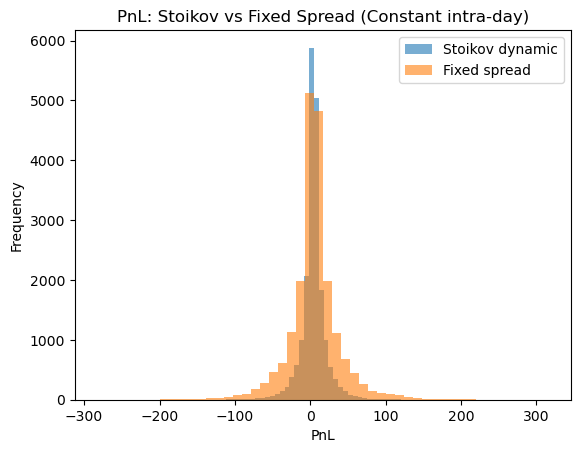

In [328]:
stoikov_constant_single_day(n_paths, n_steps, S0, K, r, sigma, gamma, A, B, C, D, jump_prob, jump_mu, jump_sigma, T_mat, T, dt)

Fill counts (dynamic): {'s_buy': 341791, 's_sell': 342453, 'o_buy': 399007, 'o_sell': 398888}
Fill counts (fixed):   {'s_buy': 400833, 's_sell': 400731, 'o_buy': 400633, 'o_sell': 400481}
Dynamic mean/std: 4.35541325969586 5.7062387874337075
Fixed mean/std:   4.422771005831555 12.95269077044537


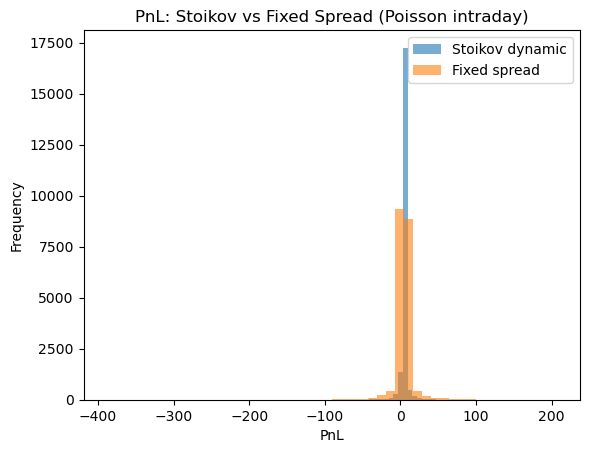

In [330]:
stoikov_poisson_single_day(n_paths, n_steps, S0, K, r, sigma, gamma, A, B, C, D, jump_lambda, jump_mu, jump_sigma, T_mat, T, dt, random_seed=None)

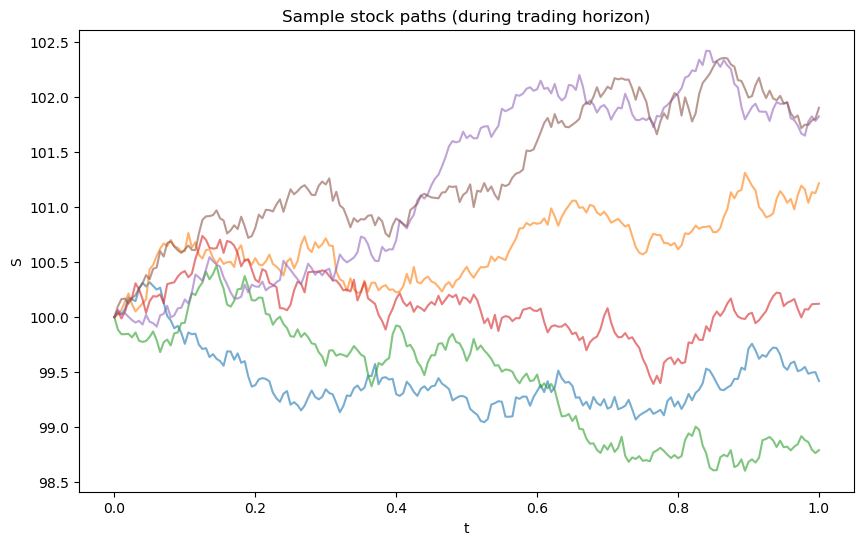

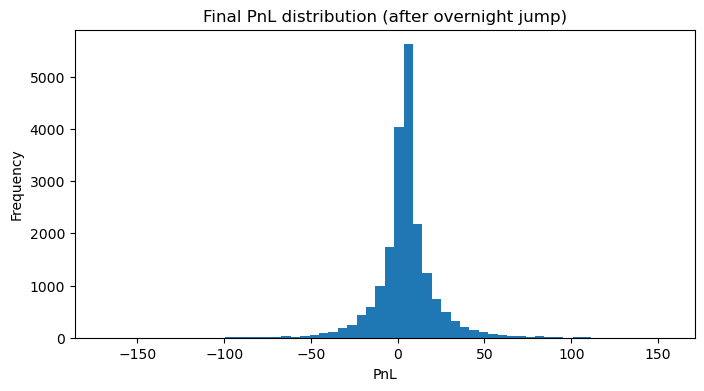

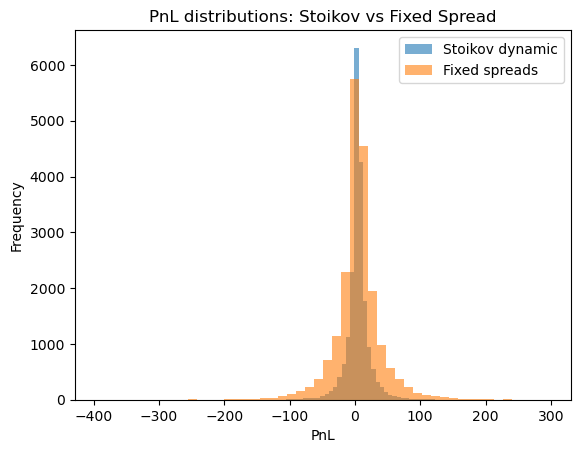

Dynamic quotes mean=4.6320, std=17.7045
Fixed spreads mean=4.4727, std=36.4974


In [332]:
stoikov_gbm_single_day(n_steps, tau, S, K, r, sigma, gamma, A, B, C, D, mu, jump_prob, jump_mu, jump_sigma, T_mat, dt)